# Key words exploration test

The objective of this section is to explore reviews in an attempt to find new keywords to add to the dictionary for keyword extraction. 
The procedure is as follows:
1. For each category, perform TF-IDF to identify the most symbolic words in the reviews
2. To better identify discriminatory words, remove some of the common words using a ratio system
3. Implementation of a topic modeling method: NMF
4. LDA
5. Correlated model topic

In [2]:
import torch
torch.set_num_threads(4)
from transformers import pipeline
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
df = pl.read_csv("../../data/processed/Bazarre/key_words_data_hotel_reviews_1.csv")

## TF-IDF


Top words for category 'handicap':
room 0.086
hotel 0.053
stay 0.039
staff 0.036
handicap 0.035
clean 0.031
great 0.03
nice 0.029
breakfast 0.029
accessible 0.029

Top words for category 'pet':
hotel 0.061
room 0.06
friendly 0.058
pet 0.051
dog 0.051
great 0.044
stay 0.043
clean 0.039
staff 0.035
dogs 0.035

Top words for category 'child':
hotel 0.057
room 0.056
family 0.052
stay 0.044
great 0.043
staff 0.038
clean 0.037
kids 0.036
pool 0.035
breakfast 0.034


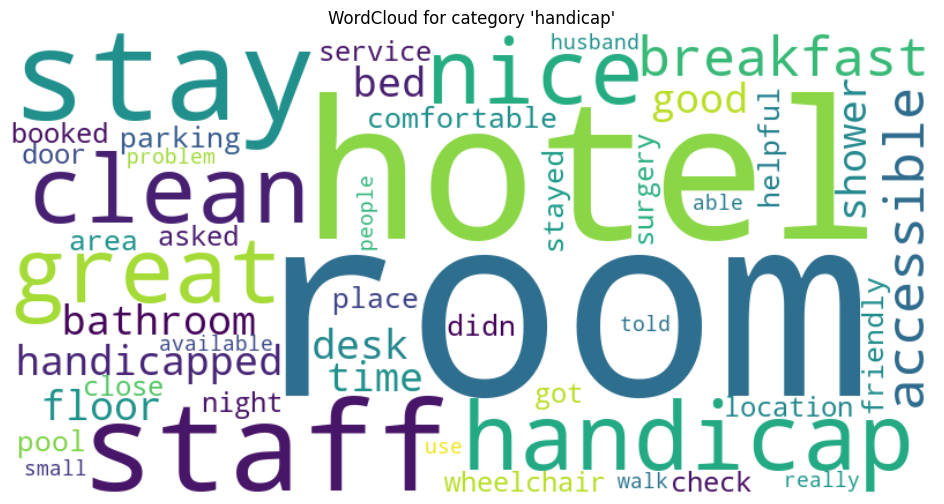

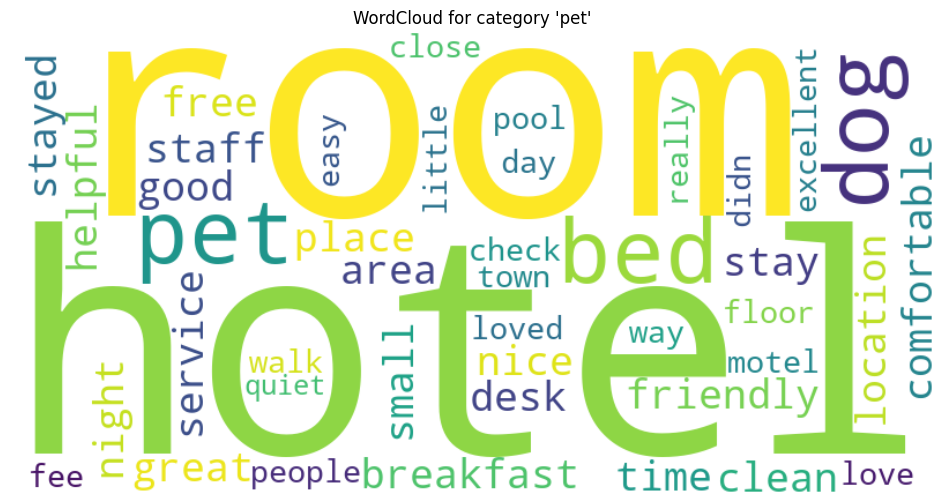

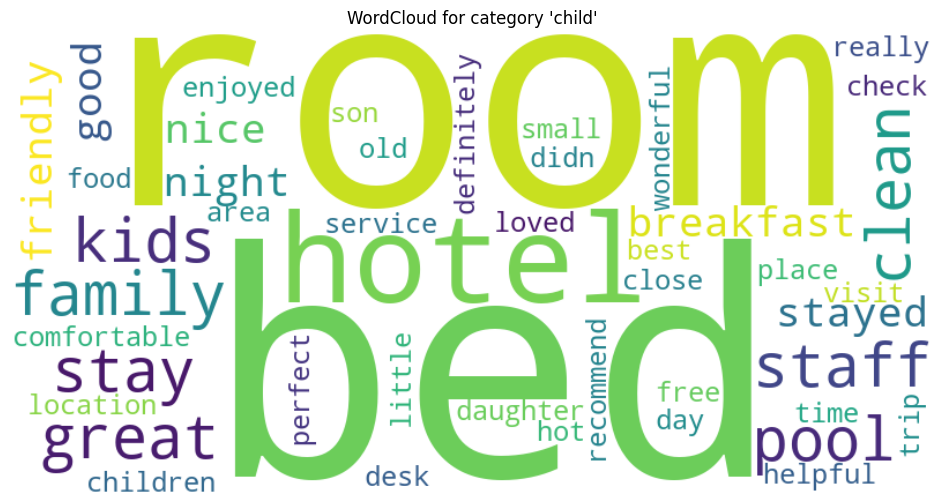

In [4]:
# -------------------------------
#  TF-IDF analysis per category
# -------------------------------

categories_of_interest = ["handicap", "pet", "child"]
vectorizer = TfidfVectorizer(stop_words="english", lowercase=True, max_features=1000)

tfidf_per_category = {}

for cat in categories_of_interest:
    reviews_cat = df.filter(pl.col("category") == cat)["review"].to_list()
    if len(reviews_cat) == 0:
        continue
    X = vectorizer.fit_transform(reviews_cat)
    feature_names = vectorizer.get_feature_names_out()
    avg_tfidf = X.mean(axis=0).A1  # average TF-IDF per word
    tfidf_per_category[cat] = sorted(
        zip(feature_names, avg_tfidf),
        key=lambda x: x[1],
        reverse=True
    )

# -------------------------------
# 5. Display top words per category
# -------------------------------
for cat in categories_of_interest:
    print(f"\nTop words for category '{cat}':")
    if cat in tfidf_per_category:
        for word, score in tfidf_per_category[cat][:10]:
            print(word, round(score, 3))
    else:
        print("No reviews in this category.")

# -------------------------------
# 6. Optional: WordCloud per category
# -------------------------------
for cat in categories_of_interest:
    if cat not in tfidf_per_category:
        continue
    text = " ".join([w for w, score in tfidf_per_category[cat][:50]])  # top 50 words
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(12, 6))
    plt.title(f"WordCloud for category '{cat}'")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


Les resultats de TF IDF sont indépendants pour chque catégorie. Si on veut pouvoir comprare les resultats entre les catégories (utiles pour faire émerger des points commun dans les besoins, ou si on fait une TF IDF sur des sous catégories definies par la suite), il faudra changer le code 

In [5]:
all_reviews = df["review"].to_list()
vectorizer = TfidfVectorizer(stop_words="english", lowercase=True, max_features=5000)
vectorizer.fit(all_reviews)

tfidf_per_category = {}
for cat in categories_of_interest:
    reviews_cat = df.filter(pl.col("category") == cat)["review"].to_list()
    if not reviews_cat:
        continue
    X = vectorizer.transform(reviews_cat)             # <-- transform, pas fit_transform
    avg_tfidf = X.mean(axis=0).A1
    tfidf_per_category[cat] = sorted(zip(vectorizer.get_feature_names_out(), avg_tfidf),
                                     key=lambda x: x[1], reverse=True)
    
for cat in categories_of_interest:
    print(f"\nTop words for category '{cat}':")
    if cat in tfidf_per_category:
        for word, score in tfidf_per_category[cat][:10]:
            print(word, round(score, 3))
    else:
        print("No reviews in this category.")



Top words for category 'handicap':
room 0.084
handicap 0.056
accessible 0.04
handicapped 0.039
hotel 0.038
stay 0.028
staff 0.027
floor 0.026
bathroom 0.026
shower 0.025

Top words for category 'pet':
dog 0.071
pet 0.071
friendly 0.063
hotel 0.05
room 0.047
dogs 0.043
great 0.036
stay 0.035
pets 0.033
clean 0.032

Top words for category 'child':
family 0.05
hotel 0.046
room 0.044
stay 0.036
great 0.036
kids 0.032
staff 0.031
clean 0.031
pool 0.031
breakfast 0.028



Discriminant TF-IDF words for 'handicap':
['handicap', 'accessible', 'handicapped', 'wheelchair', 'surgery', 'ramp', 'walker', 'ada', 'maneuver', 'grab']
(count: 231 )

Discriminant TF-IDF words for 'pet':
['barking', 'cat', 'birds', 'cats', 'laquinta', 'kimpton', 'poop', 'allows', 'tails', 'welcomed']
(count: 165 )

Discriminant TF-IDF words for 'child':
['disneyland', 'child', 'swim', 'members', 'getaway', 'kid', 'variety', 'birthday', 'ages', 'crib']
(count: 128 )


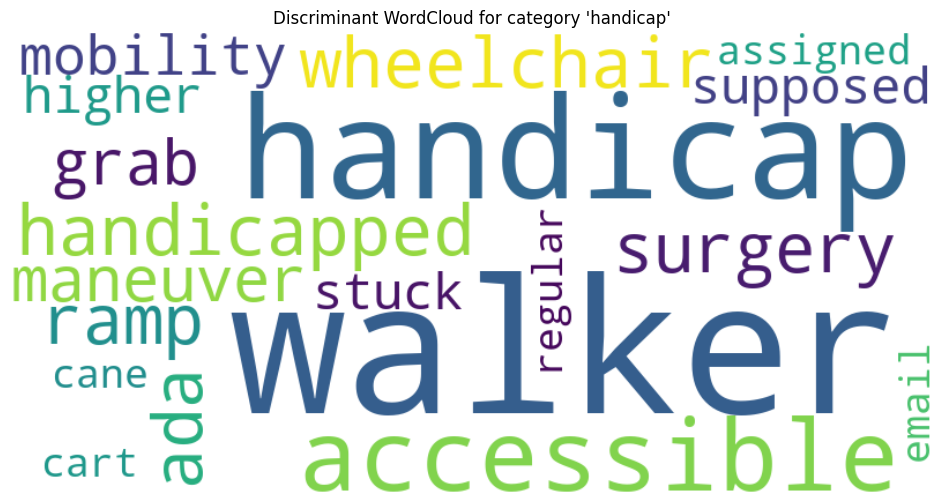

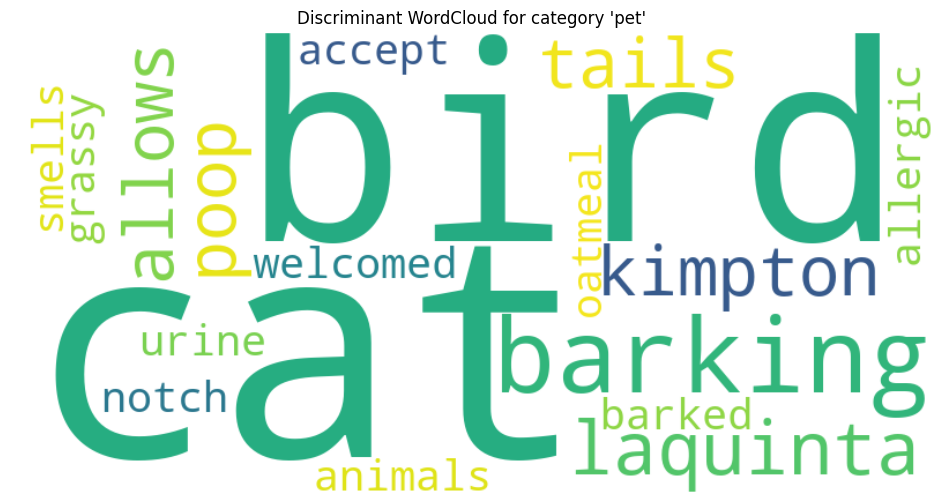

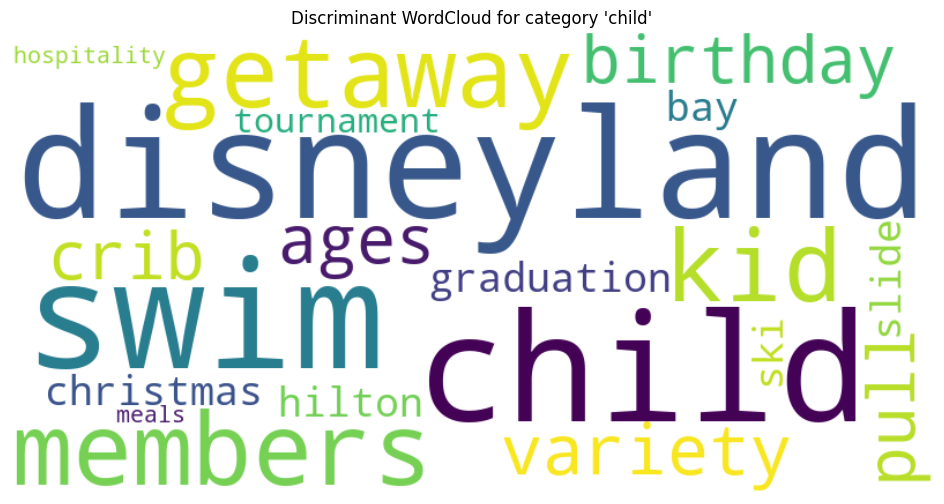

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ---------------------------------------------
# 1. You already computed tfidf_per_category
# Structure: { category : [(word, score), ... sorted desc] }
# ---------------------------------------------

categories = list(tfidf_per_category.keys())

# ---------------------------------------------
# 2. Extract only the words per category
# ---------------------------------------------
words_per_category = {
    cat: set([w for w, score in tfidf_per_category[cat]])
    for cat in categories
}

# ---------------------------------------------
# 3. Compute discriminant words
# ---------------------------------------------
discriminant_words = {}

for cat in categories:
    other_words = set()
    for other_cat in categories:
        if other_cat != cat:
            other_words.update(words_per_category[other_cat])

    # words that appear ONLY in this category
    discriminant_words[cat] = words_per_category[cat] - other_words

# ---------------------------------------------
# 4. Preserve original TF-IDF ranking
# ---------------------------------------------
top_discriminant_words = {}

for cat in categories:
    original_ranked_words = [w for w, score in tfidf_per_category[cat]]
    unique_set = discriminant_words[cat]

    # keep only discriminant words in TF-IDF order
    top_discriminant_words[cat] = [
        w for w in original_ranked_words if w in unique_set
    ]

# ---------------------------------------------
# 5. Print the top discriminant words
# ---------------------------------------------
for cat in categories:
    print(f"\nDiscriminant TF-IDF words for '{cat}':")
    print(top_discriminant_words[cat][:10])  # top 10
    print("(count:", len(top_discriminant_words[cat]), ")")

# ---------------------------------------------
# 6. WordClouds of discriminant words
# ---------------------------------------------
for cat in categories:
    if len(top_discriminant_words[cat]) == 0:
        continue

    top_words_text = " ".join(top_discriminant_words[cat][:20])

    wc = WordCloud(width=800, height=400, background_color="white").generate(top_words_text)

    plt.figure(figsize=(12, 6))
    plt.title(f"Discriminant WordCloud for category '{cat}'")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


## Retirer les mots discriminants par ration

In [5]:
from collections import defaultdict

TOP_K = 80         # mots importants dans une catégorie
MIN_RANK = 200     # rang max dans les autres pour être considéré insignifiant
RATIO = 2.0        # ratio TF-IDF dominant

# -------------------------------
# 1. Create helper structures
# -------------------------------
# Rank of each word in each category
rank_per_cat = {}
tfidf_value = {}

for cat, word_scores in tfidf_per_category.items():
    rank_per_cat[cat] = {}
    tfidf_value[cat] = {}

    for rank, (word, score) in enumerate(word_scores):
        rank_per_cat[cat][word] = rank
        tfidf_value[cat][word] = score

# -------------------------------
# 2. Compute discriminant words
# -------------------------------
discriminant_words = defaultdict(list)

for cat in categories_of_interest:
    if cat not in tfidf_per_category:
        continue

    for (word, score) in tfidf_per_category[cat][:TOP_K]:  # only top words in target cat

        is_discriminant = True

        for other_cat in categories_of_interest:
            if other_cat == cat:
                continue

            # if word exists in other category
            if word in rank_per_cat[other_cat]:

                rank_other = rank_per_cat[other_cat][word]
                score_other = tfidf_value[other_cat][word]

                # condition 1 : not too high ranked in other categories
                if rank_other < MIN_RANK:
                    # condition 2 : apply ratio condition
                    if score <= RATIO * score_other:
                        is_discriminant = False
                        break

        if is_discriminant:
            discriminant_words[cat].append(word)

# -------------------------------
# 3. Print results
# -------------------------------
for cat in discriminant_words:
    print(f"\nDiscriminant words for '{cat}':")
    print(discriminant_words[cat][:20])
    print("Total:", len(discriminant_words[cat]))



Discriminant words for 'handicap':
['handicap', 'accessible', 'handicapped', 'bathroom', 'shower', 'parking', 'wheelchair', 'asked', 'surgery', 'problem', 'able', 'given', 'ramp', 'walker', 'person', 'hard']
Total: 16

Discriminant words for 'pet':
['friendly', 'pet', 'dog', 'dogs', 'pets', 'fee', 'allow', 'barking']
Total: 8

Discriminant words for 'child':
['family', 'kids', 'daughter', 'children', 'visit', 'year', 'weekend', 'visiting']
Total: 8


## Topic modelling


Topic 0: great family stay hotel pool nice clean staff breakfast kid good comfortable room location area

Topic 1: room not elevator no get hotel one floor bed would night check go we desk

Topic 2: pet friendly dog hotel staff allow clean fee stay travel helpful motel love great place

Documents par topic:
Topic 0: 2138 reviews
Topic 1: 2401 reviews
Topic 2: 676 reviews


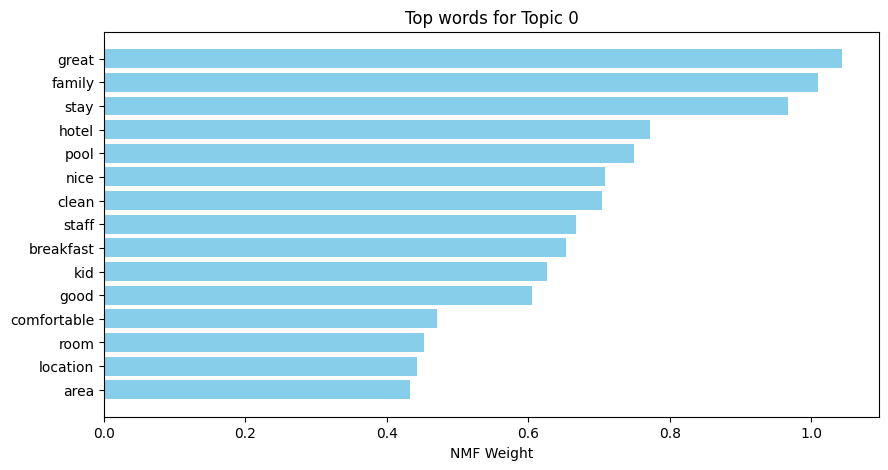

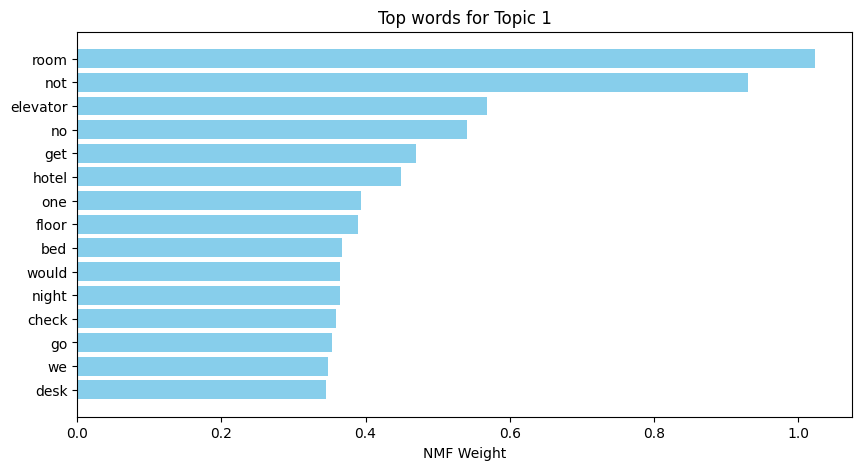

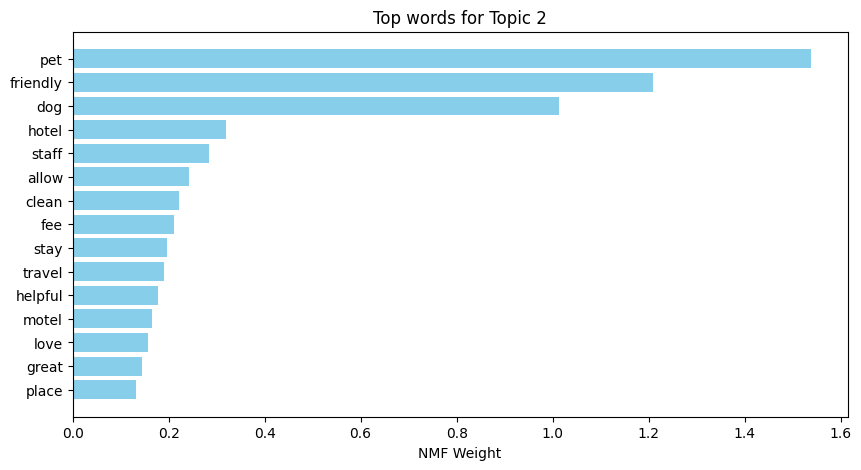

In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# -------------------------------
# 1. Charger les reviews
# -------------------------------
# df['review'] doit être déjà prétraité (minuscule, stopwords supprimés, tokenisé si besoin)
reviews = df['review'].to_list()

# -------------------------------
# 2. TF-IDF Vectorization
# -------------------------------
max_features = 5000  # ajuste selon ton corpus
vectorizer = TfidfVectorizer(max_features=max_features)
X = vectorizer.fit_transform(reviews)
feature_names = vectorizer.get_feature_names_out()

# -------------------------------
# 3. NMF Topic Modeling
# -------------------------------
n_topics = 3  # nombre de topics à découvrir
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=200)
nmf_model.fit(X)

# -------------------------------
# 4. Extraire les top words par topic
# -------------------------------
n_top_words = 15
topics = {}

for topic_idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[::-1][:n_top_words]
    top_words = [feature_names[i] for i in top_indices]
    topics[topic_idx] = top_words
    print(f"\nTopic {topic_idx}: {' '.join(top_words)}")

# -------------------------------
# 5. Associer chaque review à son topic dominant
# -------------------------------
doc_topic_dist = nmf_model.transform(X)  # shape = (n_docs, n_topics)
dominant_topics = np.argmax(doc_topic_dist, axis=1)
df = df.with_columns([
    pl.Series("dominant_topic", dominant_topics)
])

# Optionnel : afficher la proportion de documents par topic
topic_counts = (
    df.group_by("dominant_topic")  # regroupe par topic
      .len()                    # compte le nombre de reviews
      .sort("dominant_topic")     # trie par topic
)
print("\nDocuments par topic:")
for row in topic_counts.iter_rows():
    topic_idx = row[0]  # colonne dominant_topic
    count = row[1]      # colonne count
    print(f"Topic {topic_idx}: {count} reviews")

# -------------------------------
# 6. Visualisation simple : bar chart des top words par topic
# -------------------------------
for topic_idx, words in topics.items():
    plt.figure(figsize=(10, 5))
    values = nmf_model.components_[topic_idx][
        [vectorizer.vocabulary_[w] for w in words]
    ]
    plt.barh(words[::-1], values[::-1], color='skyblue')
    plt.title(f"Top words for Topic {topic_idx}")
    plt.xlabel("NMF Weight")
    plt.show()


## Test de topic modeling a l'interieur de chaque categorie

### Pet


Documents par topic:
Topic 0: 100 reviews
Topic 1: 97 reviews
Topic 2: 135 reviews
Topic 3: 185 reviews
Topic 4: 23 reviews
Topic 5: 56 reviews
Topic 6: 193 reviews
Topic 7: 62 reviews
Topic 8: 50 reviews
Topic 9: 37 reviews


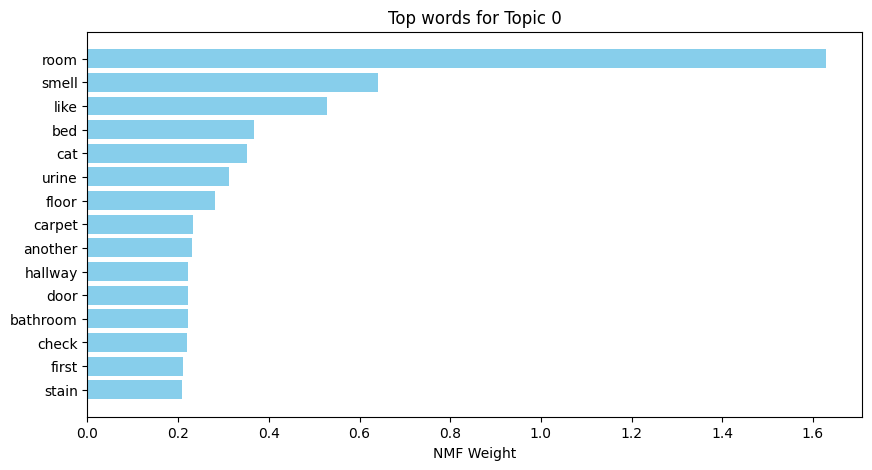

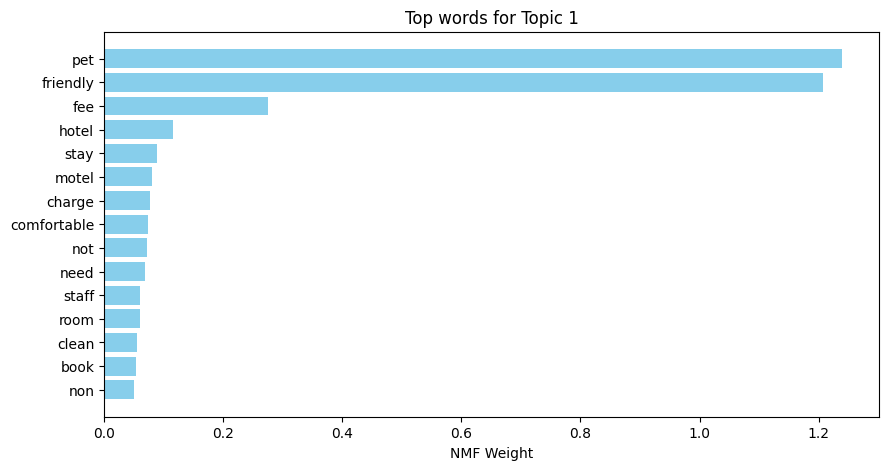

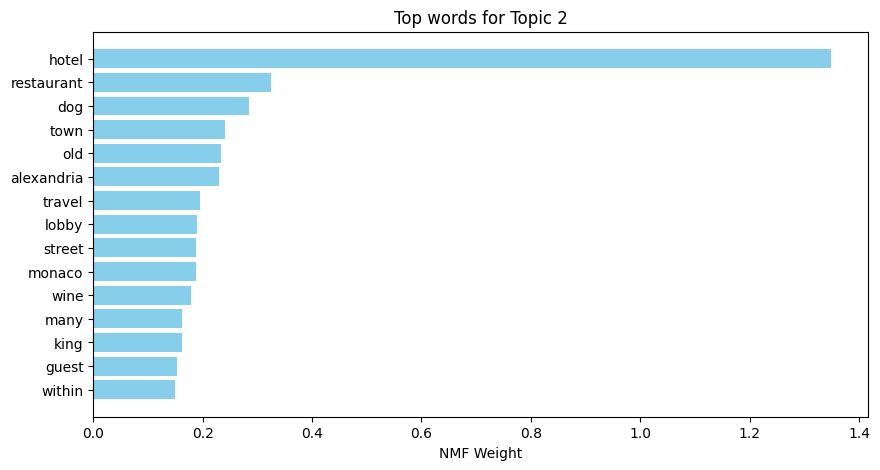

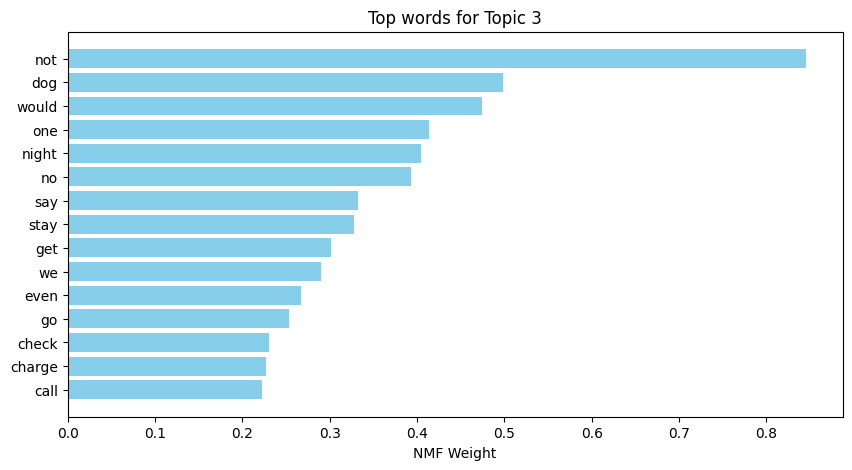

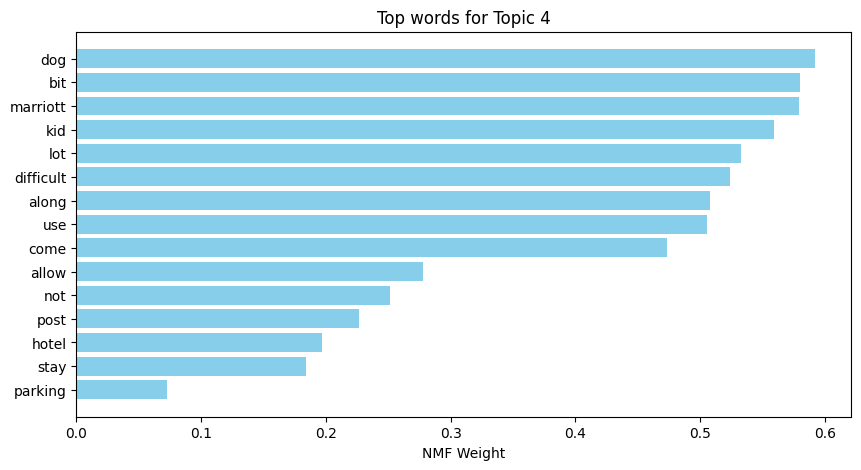

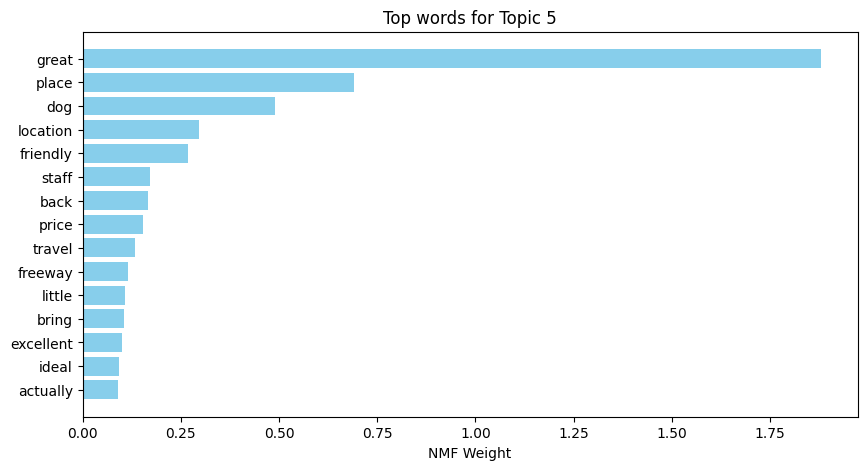

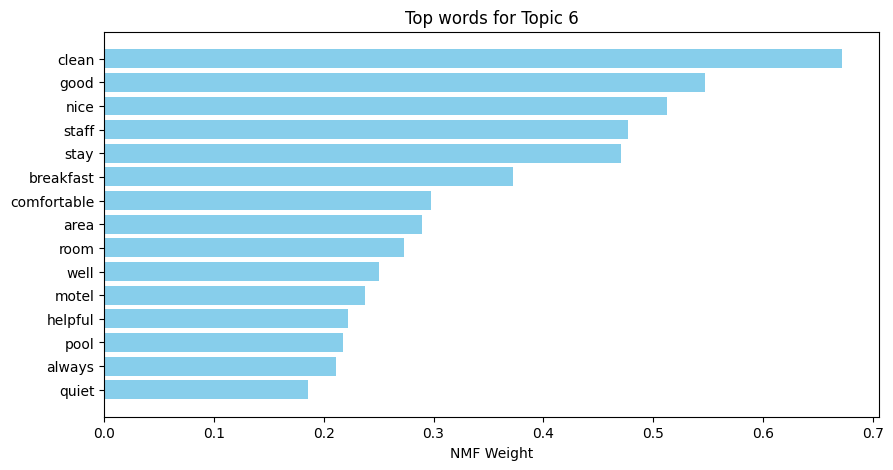

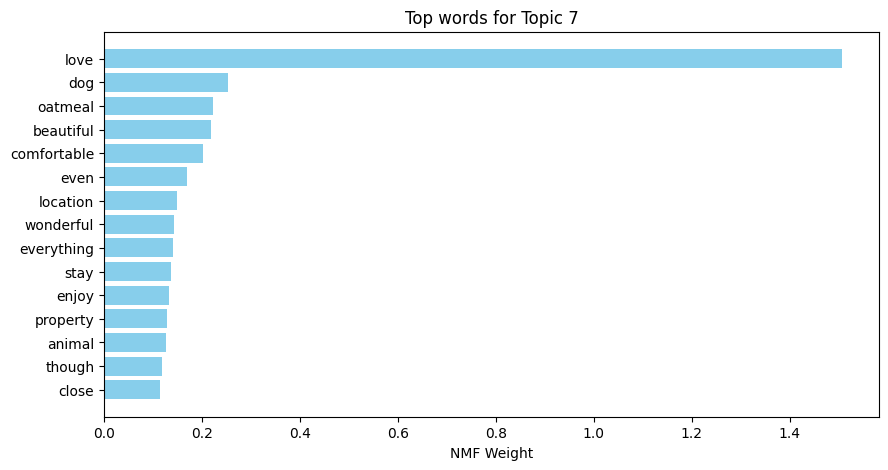

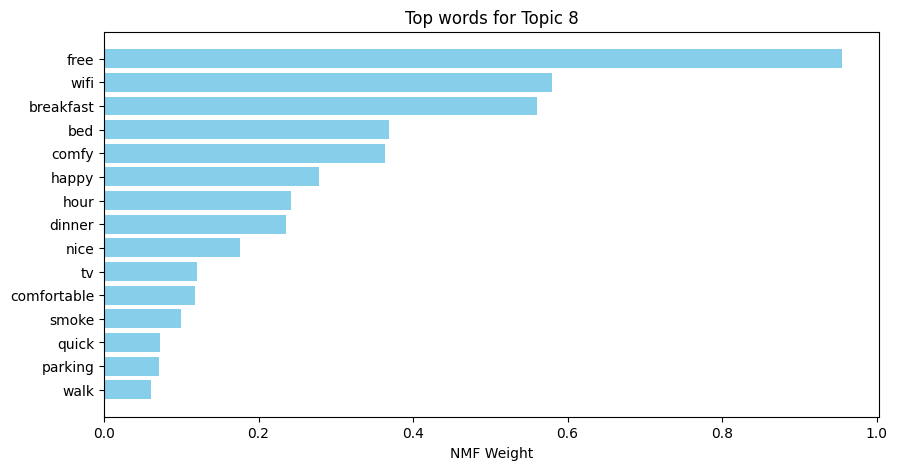

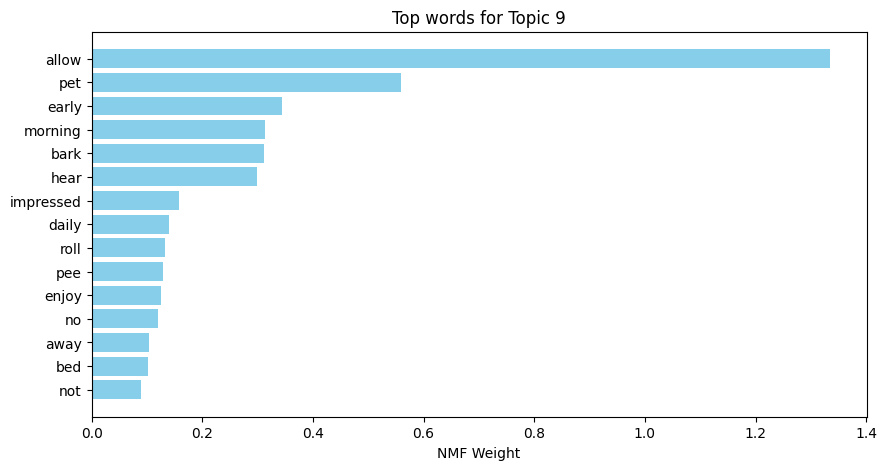

In [19]:
df = df.filter(pl.col("category") == "pet")
reviews = df['review'].to_list()

max_features = 5000  # ajuste selon ton corpus
vectorizer = TfidfVectorizer(max_features=max_features)
X = vectorizer.fit_transform(reviews)
feature_names = vectorizer.get_feature_names_out()

n_topics = 10  # nombre de topics à découvrir
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=200)
nmf_model.fit(X)

n_top_words = 15
topics = {}

for topic_idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[::-1][:n_top_words]
    top_words = [feature_names[i] for i in top_indices]
    topics[topic_idx] = top_words

doc_topic_dist = nmf_model.transform(X)  
dominant_topics = np.argmax(doc_topic_dist, axis=1)
df = df.with_columns([
    pl.Series("dominant_topic", dominant_topics)
])

# Optionnel : afficher la proportion de documents par topic
topic_counts = (
    df.group_by("dominant_topic")  # regroupe par topic
      .len()                    # compte le nombre de reviews
      .sort("dominant_topic")     # trie par topic
)
print("\nDocuments par topic:")
for row in topic_counts.iter_rows():
    topic_idx = row[0]  # colonne dominant_topic
    count = row[1]      # colonne count
    print(f"Topic {topic_idx}: {count} reviews")

for topic_idx, words in topics.items():
    plt.figure(figsize=(10, 5))
    values = nmf_model.components_[topic_idx][
        [vectorizer.vocabulary_[w] for w in words]
    ]
    plt.barh(words[::-1], values[::-1], color='skyblue')
    plt.title(f"Top words for Topic {topic_idx}")
    plt.xlabel("NMF Weight")
    plt.show()


## LDA

LDA est un modèle bayésien qui décompose un corpus en topics latents, chacun représenté par un ensemble de mots, et attribue à chaque document une proportion de ces topics. C’est l’outil classique pour le topic modeling non supervisé.


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import pyLDAvis
import polars as pl


In [7]:
df = pl.read_csv("../../data/processed/key_words_data_hotel_reviews_1.csv")
#df = df.filter(pl.col("category") == "pet")
documents = df["review"].to_list()

dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

# --- 4. Entraîner le modèle LDA ---
num_topics = 3  # on suppose 2 topics dans ce corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=15)

# --- 5. Afficher les topics ---
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# --- 6. Visualisation interactive ---
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


FileNotFoundError: Le fichier spécifié est introuvable. (os error 2): ../../data/processed/key_words_data_hotel_reviews_1.csv

In [ ]:
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import polars as pl

# --- 1. Charger ton dataset (Polars) ---
df = pl.read_csv("../../data/processed/key_words_data_hotel_reviews_1.csv")

# Filtrer par exemple la catégorie "pet" si nécessaire
#df = df.filter(pl.col("category") == "pet")
df = df.filter(pl.col("category") == "child")


# Récupérer la colonne review : chaque review est déjà tokenisée (list of words)
# Supposons que la colonne s'appelle "review_tokens"
# Si tes reviews sont sous forme de string séparés par espaces, il faut splitter :
df = df.with_columns(pl.col("review").str.split(" ").alias("review_tokens"))

documents = df["review_tokens"].to_list()  # liste de listes de tokens

# --- 2. Créer le dictionnaire et corpus pour LDA ---
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

# --- 3. Entraîner le modèle LDA ---
num_topics = 8
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=15
)

# --- 4. Afficher les topics ---
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# --- 5. Visualisation interactive ---
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


Topic 0: 0.035*"room" + 0.027*"not" + 0.017*"hotel" + 0.012*"stay" + 0.011*"no" + 0.011*"get" + 0.011*"would" + 0.010*"bed" + 0.010*"night" + 0.009*"one"
Topic 1: 0.028*"room" + 0.022*"stay" + 0.017*"family" + 0.017*"motel" + 0.013*"clean" + 0.011*"coffee" + 0.009*"price" + 0.009*"free" + 0.008*"night" + 0.008*"super"
Topic 2: 0.032*"el" + 0.029*"la" + 0.029*"de" + 0.018*"las" + 0.017*"que" + 0.016*"no" + 0.015*"los" + 0.015*"en" + 0.014*"son" + 0.013*"para"
Topic 3: 0.037*"hotel" + 0.021*"stay" + 0.017*"family" + 0.015*"room" + 0.012*"child" + 0.008*"year" + 0.008*"night" + 0.007*"walk" + 0.007*"inn" + 0.007*"free"
Topic 4: 0.026*"de" + 0.016*"le" + 0.015*"la" + 0.014*"et" + 0.010*"se" + 0.009*"pour" + 0.008*"est" + 0.008*"les" + 0.006*"un" + 0.006*"des"
Topic 5: 0.033*"breakfast" + 0.025*"hotel" + 0.024*"stay" + 0.012*"family" + 0.012*"good" + 0.012*"free" + 0.010*"not" + 0.009*"clean" + 0.009*"room" + 0.009*"kid"
Topic 6: 0.026*"stay" + 0.025*"family" + 0.023*"great" + 0.023*"hotel"

## Correlated Model Topic

Resultat completement nul, abérant, a retravailler 

In [16]:
# ===============================
# 1. Imports
# ===============================
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
import polars as pl

# ===============================
# 2. Chargement du dataset
# ===============================
original_df = pl.read_csv("../../data/original/dataset/data_hotel_reviews_1.csv")
keywords_df = pl.read_csv("../../data/processed/key_words_data_hotel_reviews_1.csv")

keywords_df = keywords_df.rename({"review": "kw_review"})
original_reviews = original_df.select(["id", "review"])
df = keywords_df.join(original_reviews, on="id", how="left")
df = df.group_by('id').agg(
    pl.col('review').first(), 
    pl.col('category').cast(pl.Utf8).str.join(delimiter=' ')
)

documents = df["review"].to_list()

# ===============================
# 3. Préprocessing minimal
# ===============================
documents_joined = [
    " ".join(tokens) if isinstance(tokens, list) else str(tokens)
    for tokens in documents
]

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

documents_clean = []
for doc in documents_joined:
    # transformer en liste de mots
    words = doc.lower().split()
    # enlever les stopwords
    words = [w for w in words if w not in stop_words]
    # reconstruire la phrase
    documents_clean.append(" ".join(words))

# ===============================
# 4. Préparation des données CTM
# ===============================
tp = TopicModelDataPreparation("all-MiniLM-L6-v2")

training_dataset = tp.fit(
    text_for_contextual=documents_joined,
    text_for_bow=documents_joined
)

# ===============================
# 5. Modèle CTM
# ===============================
num_topics = 3

ctm = CombinedTM(
    bow_size=len(tp.vocab),
    contextual_size=384,  # Taille de MiniLM-L6-v2
    n_components=num_topics,
    num_epochs=5,
)

ctm.fit(training_dataset)

# ===============================
# 6. Affichage des topics
# ===============================
topics = ctm.get_topic_lists(10)
for idx, words in enumerate(topics):
    print(f"Topic {idx}: {words}")

# ===============================
# 7. Attribution des topics
# ===============================
topic_distribution = ctm.get_doc_topic_distribution(training_dataset)
dominant_topics = topic_distribution.argmax(axis=1)

df_result = df.with_columns(
    pl.Series("dominant_topic", dominant_topics)
)

print(df_result)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\contextualized_topic_models\utils\data_preparation.py:64: UserWarning: the longest document in your collection has 717 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [5/5]	 Seen Samples: [24640/24860]	Train Loss: 596.6989048549107	Time: 0:00:20.080078: : 5it [01:49, 21.81s/it]
100%|██████████| 78/78 [00:15<00:00,  5.09it/s]


Topic 0: ['sorta', 'absorb', 'upward', 'bananas', 'gossiping', 'impeccable', 'eau', 'shares', 'noone', 'bnb']
Topic 1: ['there', 'have', 'we', 'the', 'but', 'this', 'their', 'could', 'were', 'for']
Topic 2: ['pleasent', 'symbol', 'ample', '168', 'napping', 'epic', 'importat', 'sorta', 'vibrant', 'unbeknown']


100%|██████████| 78/78 [00:16<00:00,  4.79it/s]

shape: (4_972, 4)
┌───────┬─────────────────────────────────┬──────────┬────────────────┐
│ id    ┆ review                          ┆ category ┆ dominant_topic │
│ ---   ┆ ---                             ┆ ---      ┆ ---            │
│ i64   ┆ str                             ┆ str      ┆ i64            │
╞═══════╪═════════════════════════════════╪══════════╪════════════════╡
│ 19323 ┆ We stayed here 30 yrs ago but … ┆ child    ┆ 0              │
│ 34111 ┆ Comfortable place to stay for … ┆ child    ┆ 2              │
│ 920   ┆ The hotel was very mediocre - … ┆ pet      ┆ 1              │
│ 11031 ┆ Had availability when most wer… ┆ handicap ┆ 2              │
│ 34257 ┆ This is a nice little resort s… ┆ pet      ┆ 0              │
│ …     ┆ …                               ┆ …        ┆ …              │
│ 26605 ┆ I ended up not staying at the … ┆ pet      ┆ 1              │
│ 15940 ┆ Stayed Sunday night over MLK w… ┆ child    ┆ 1              │
│ 21061 ┆ If you have kids or prefer to … ┆ ch

In [23]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
import polars as pl
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

original_df = pl.read_csv("../../data/original/dataset/data_hotel_reviews_1.csv")
keywords_df = pl.read_csv("../../data/processed/key_words_data_hotel_reviews_1.csv")

keywords_df = keywords_df.rename({"review": "kw_review"})
df = keywords_df.join(original_df.select(["id", "review"]), on="id", how="left")
df = df.group_by('id').agg(
    pl.col('review').first(), 
    pl.col('category').cast(pl.Utf8).str.join(delimiter=' ')
)

documents = df["review"].to_list()
documents_joined = [
    " ".join(tokens) if isinstance(tokens, list) else str(tokens)
    for tokens in documents
]

documents_clean = []
for doc in documents_joined:
    words = doc.lower().split()
    words = [w for w in words if w not in stop_words]
    documents_clean.append(" ".join(words))

tp = TopicModelDataPreparation("all-MiniLM-L6-v2")
training_dataset = tp.fit(
    text_for_contextual=documents_clean,
    text_for_bow=documents_clean
)

num_topics = 3
ctm = CombinedTM(
    bow_size=len(tp.vocab),
    contextual_size=384,
    n_components=num_topics,
    num_epochs=20
)

ctm.fit(training_dataset)

topics = ctm.get_topic_lists(10)
for idx, words in enumerate(topics):
    print(f"Topic {idx}: {words}")

topic_distribution = ctm.get_doc_topic_distribution(training_dataset)
dominant_topics = topic_distribution.argmax(axis=1)

df_result = df.with_columns(
    pl.Series("dominant_topic", dominant_topics)
)

print(df_result)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\contextualized_topic_models\utils\data_preparation.py:64: UserWarning: the longest document in your collection has 351 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [20/20]	 Seen Samples: [98560/99440]	Train Loss: 331.45550259676844	Time: 0:00:19.740985: : 20it [07:07, 21.36s/it]
100%|██████████| 78/78 [00:15<00:00,  5.13it/s]


Topic 0: ['greece', 'drawer', '31st', 'snorkel', 'erred', 'bugging', 'bounch', 'backthank', 'pts', 'payed']
Topic 1: ['in', 'like', 'check', 'one', 'bed', 'small', 'room', 'two', 'also', 'made']
Topic 2: ['restaurants', 'great', 'location', 'amazing', 'business', 'age', 'fitness', 'best', 'comfortable', 'shopping']


100%|██████████| 78/78 [00:15<00:00,  5.11it/s]

shape: (4_972, 4)
┌───────┬─────────────────────────────────┬──────────┬────────────────┐
│ id    ┆ review                          ┆ category ┆ dominant_topic │
│ ---   ┆ ---                             ┆ ---      ┆ ---            │
│ i64   ┆ str                             ┆ str      ┆ i64            │
╞═══════╪═════════════════════════════════╪══════════╪════════════════╡
│ 16146 ┆ We booked this hotel because i… ┆ child    ┆ 1              │
│ 6172  ┆ Beyond the incredible views of… ┆ pet      ┆ 0              │
│ 3716  ┆ We had to get away from hurric… ┆ pet      ┆ 1              │
│ 18007 ┆ My family and I have been rent… ┆ child    ┆ 0              │
│ 25450 ┆ Room was comfortable and clean… ┆ child    ┆ 2              │
│ …     ┆ …                               ┆ …        ┆ …              │
│ 22925 ┆ the front desk male rep was ve… ┆ child    ┆ 0              │
│ 22621 ┆ Good stay for 12 nights, Allow… ┆ pet      ┆ 2              │
│ 29987 ┆ Nearly slipped and fell in the… ┆ ha

dominant_topic        0    1     2
category                          
child               959  775  1174
handicap            465  409   160
handicap child       18   56    18
handicap pet         10   14     4
handicap pet child    2    2     0
pet                 281  286   224
pet child            27   44    44


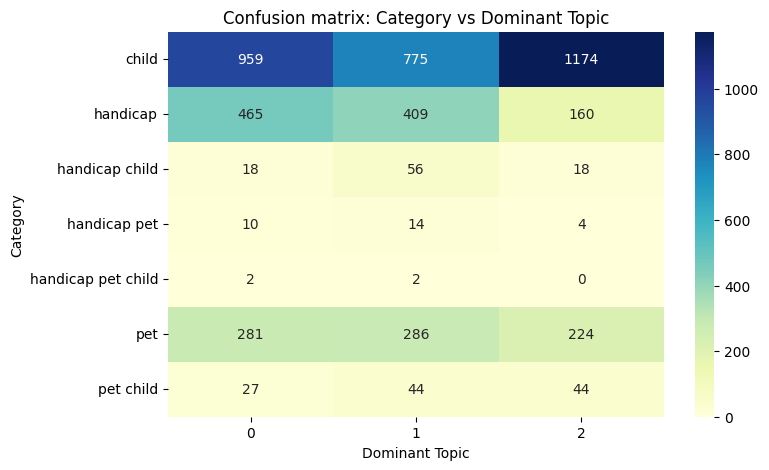

In [25]:
# ===============================
# Imports pour la visualisation
# ===============================
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===============================
# Charger ou utiliser ton df_result
# ===============================
# df_result est ton Polars DataFrame avec "category" et "dominant_topic"
# On le convertit en Pandas pour seaborn
df_pd = df_result.select(["category", "dominant_topic"]).to_pandas()

# ===============================
# Créer la "matrice de confusion" / crosstab
# ===============================
conf_matrix = pd.crosstab(df_pd["category"], df_pd["dominant_topic"])

print(conf_matrix)

# ===============================
# Tracer la heatmap
# ===============================
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion matrix: Category vs Dominant Topic")
plt.xlabel("Dominant Topic")
plt.ylabel("Category")
plt.show()


In [17]:
documents_joined = [
    " ".join(tokens) if isinstance(tokens, list) else str(tokens)
    for tokens in documents
]

# Vérifier un échantillon
for doc in documents_joined[:5]:
    print(doc)

We stayed here 30 yrs ago but it has declined. The room had been broken into, the door jam destroyed and never fixed, could not lock the door it was so bent up. Totally unsafe!! Toilet ran water all night. Place needs a lot of maintenance but no one seems to care. A 3 year old kid could now kick... More
Comfortable place to stay for Thanksgiving weekend. Close to shops / family / food.
The hotel was very mediocre - even less than what you would expect from a Super 8. Also, upon check-in, they assessed me an extra 15.00 fee for my dog even though that fee was not disclosed on Hotels.com or the Super 8 hotel interconnect on Policies that is part of the Hotels.com website. Thus the hotel stay turned out to be an 80. a night deal which is more than the amount a rational person would want to pay to stay at a Super 8.
Had availability when most were all booked up. Nice staff, room was clean, needed some redecorating and a face lift but was ok for the money
This is a nice little resort situat

## Graphe de co-occurence

In [ ]:
## Pas bien compris ce que ca faisait. L'affichage est horrible

import pandas as pd
import networkx as nx
from collections import Counter
from pyvis.network import Network

df = pd.read_csv("../../data/processed/key_words_data_hotel_reviews_1.csv")
reviews = df['review'].dropna().tolist()

window_size = 2
top_n_words = 10

all_words = [word for review in reviews for word in review.split()]
word_counts = Counter(all_words)
most_common_words = set([word for word, _ in word_counts.most_common(top_n_words)])

G = nx.Graph()

for review in reviews:
    words = [word for word in review.split() if word in most_common_words]
    for i in range(len(words)):
        for j in range(i+1, min(i+window_size+1, len(words))):
            if G.has_edge(words[i], words[j]):
                G[words[i]][words[j]]['weight'] += 1
            else:
                G.add_edge(words[i], words[j], weight=1)

net = Network(height="800px", width="100%", notebook=True)

for node in G.nodes():
    net.add_node(node, size=word_counts[node]*5, title=node)

for u, v, data in G.edges(data=True):
    net.add_edge(u, v, value=data['weight'])

net.force_atlas_2based()
net.show("graphe_cooccurrence.html")


graphe_cooccurrence.html


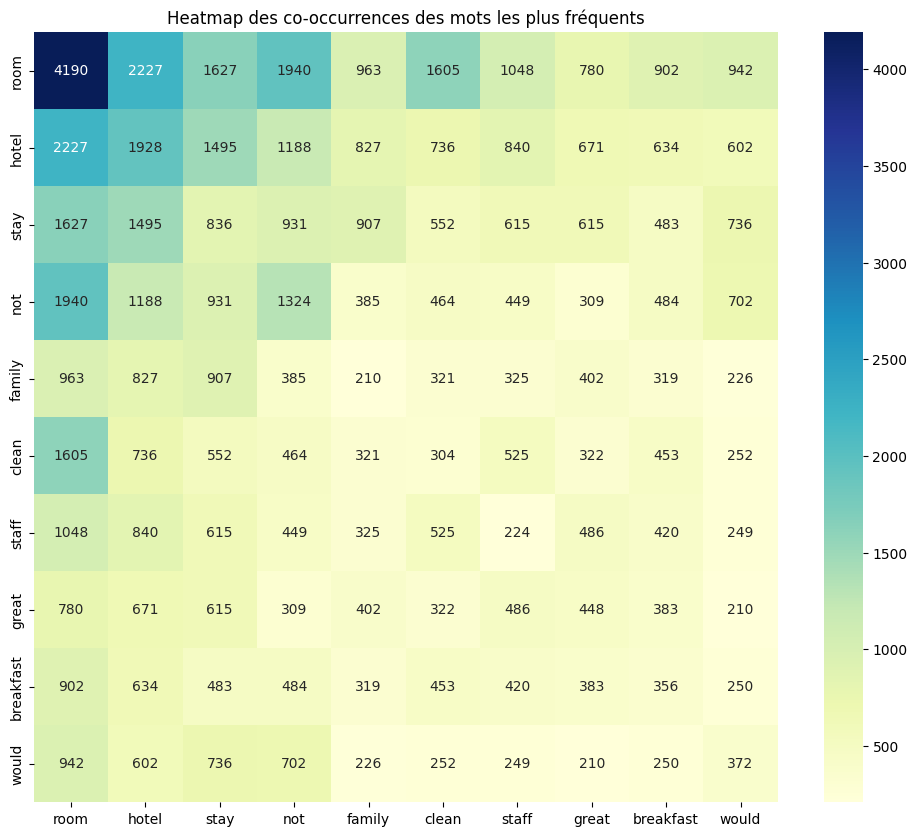

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv("../../data/processed/key_words_data_hotel_reviews_1.csv")
reviews = df['review'].dropna().tolist()

top_n_words = 10
all_words = [word for review in reviews for word in review.split()]
word_counts = Counter(all_words)
most_common_words = [word for word, _ in word_counts.most_common(top_n_words)]

# Initialiser la matrice de co-occurrence
cooc_matrix = pd.DataFrame(0, index=most_common_words, columns=most_common_words)

window_size = 2

for review in reviews:
    words = [word for word in review.split() if word in most_common_words]
    for i in range(len(words)):
        for j in range(i+1, min(i+window_size+1, len(words))):
            cooc_matrix.loc[words[i], words[j]] += 1
            cooc_matrix.loc[words[j], words[i]] += 1

plt.figure(figsize=(12,10))
sns.heatmap(cooc_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap des co-occurrences des mots les plus fréquents")
plt.show()


## Co-occurence

In [37]:
from collections import Counter, defaultdict
from itertools import combinations

# Liste de listes de mots pour chaque document
documents_tokens = [doc.split() for doc in documents_clean]


In [38]:
co_occurrence = defaultdict(int)

for tokens in documents_tokens:
    # Pour chaque paire unique de mots dans un document
    for w1, w2 in combinations(set(tokens), 2):
        # On trie les mots pour que ('hotel', 'room') = ('room', 'hotel')
        pair = tuple(sorted([w1, w2]))
        co_occurrence[pair] += 1

# Convertir en liste triée par fréquence
co_occurrence_sorted = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)

# Afficher les 20 co-occurrences les plus fréquentes
for (w1, w2), count in co_occurrence_sorted[:20]:
    print(f"{w1} - {w2}: {count}")


hotel - room: 856
hotel - staff: 628
hotel - stay: 608
room - stay: 606
room - staff: 544
room - would: 527
breakfast - room: 505
breakfast - hotel: 482
hotel - would: 468
stay - would: 463
family - hotel: 456
family - room: 445
one - room: 424
hotel - stayed: 417
clean - room: 412
great - hotel: 407
room - stayed: 407
desk - front: 398
hotel - rooms: 387
hotel - one: 385


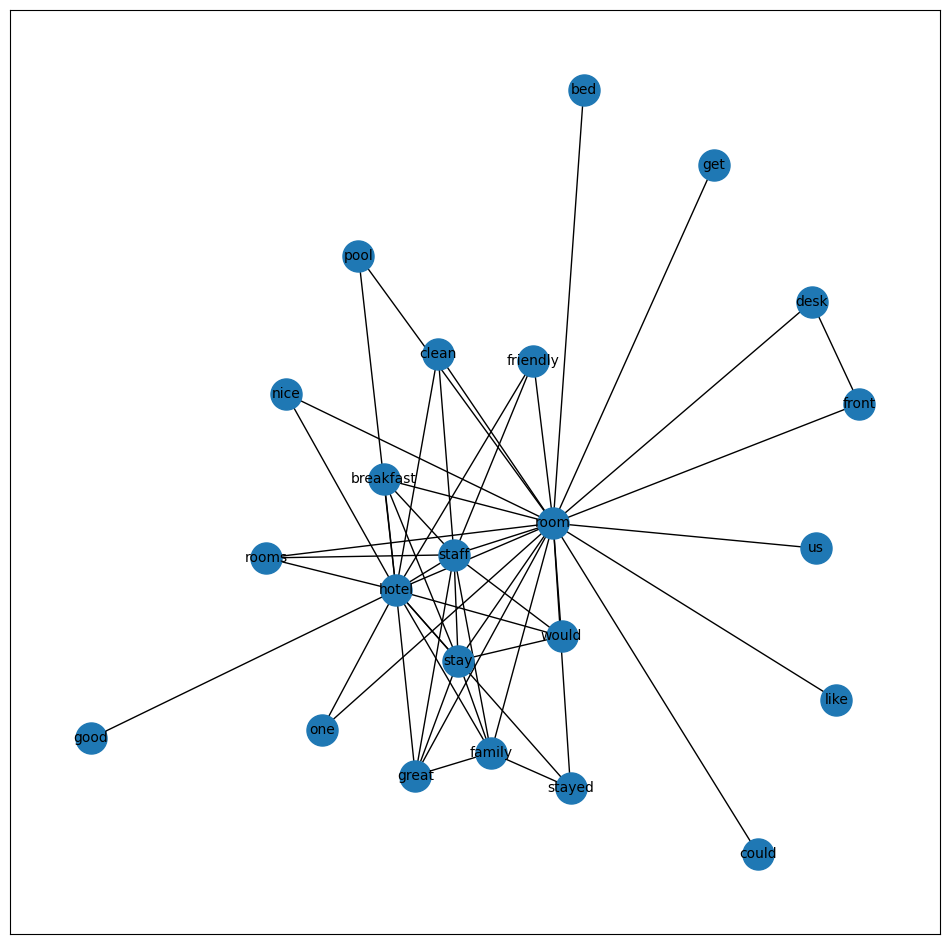

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# On prend par exemple les 50 co-occurrences les plus fréquentes
for (w1, w2), count in co_occurrence_sorted[:50]:
    G.add_edge(w1, w2, weight=count)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx(G, pos, with_labels=True, node_size=500, font_size=10)
plt.show()


### Avec target words

In [41]:
from collections import defaultdict
from itertools import combinations

# Liste de tokens pour chaque document
documents_tokens = [doc.split() for doc in documents_clean]

# Mots qui t'intéressent
target_words = {"family", "child"}

# Dictionnaire pour stocker les co-occurrences avec les mots cibles
co_occurrence_target = defaultdict(int)

for tokens in documents_tokens:
    token_set = set(tokens)
    for target in target_words:
        if target in token_set:
            for word in token_set:
                if word != target:
                    co_occurrence_target[(target, word)] += 1

# Trier par fréquence décroissante
co_occurrence_sorted = sorted(co_occurrence_target.items(), key=lambda x: x[1], reverse=True)

# Afficher les 10 co-occurrences les plus fréquentes
for (target, word), count in co_occurrence_sorted[:30]:
    print(f"{target} - {word}: {count}")


family - hotel: 456
family - room: 445
family - stay: 351
family - stayed: 312
family - staff: 306
family - great: 283
family - breakfast: 268
family - would: 235
family - clean: 230
family - rooms: 223
family - one: 194
family - nice: 188
family - place: 161
family - pool: 159
family - us: 149
family - good: 147
family - friendly: 138
family - night: 135
family - time: 134
family - front: 122
family - 2: 117
family - could: 115
family - desk: 114
family - like: 113
family - two: 111
family - well: 110
family - area: 107
family - location: 102
family - get: 102
family - enjoyed: 100


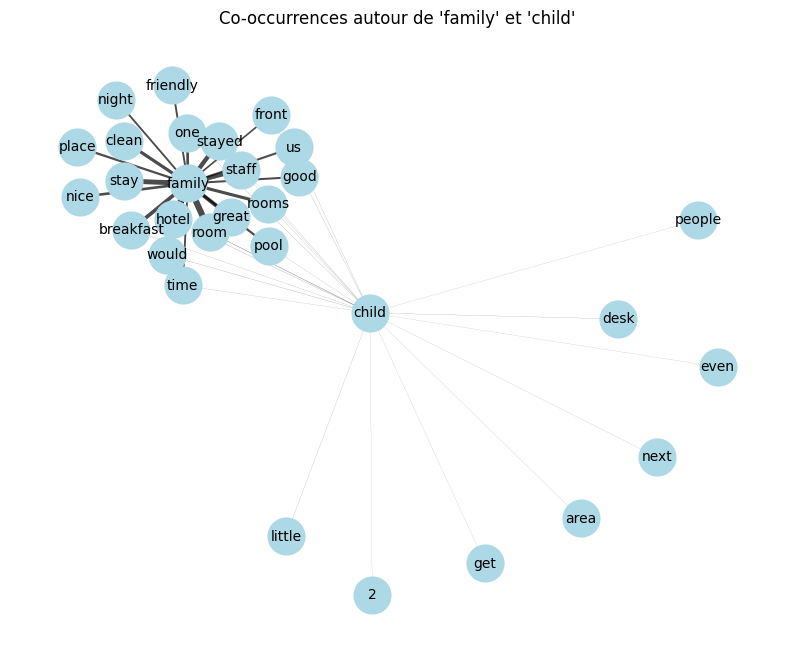

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Préparer la liste de tokens par document
documents_tokens = [doc.split() for doc in documents_clean]

# Mots d'intérêt
target_words = {"family","child"}

# Construire un dictionnaire co-occurrences avec les mots cibles
co_occurrence_target = defaultdict(int)

for tokens in documents_tokens:
    token_set = set(tokens)
    for target in target_words:
        if target in token_set:
            for word in token_set:
                if word != target:
                    co_occurrence_target[(target, word)] += 1

# Trier par fréquence et garder les top 10 pour chaque mot cible
top_edges = []
for target in target_words:
    edges = [(tgt, w, c) for (tgt, w), c in co_occurrence_target.items() if tgt == target]
    edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)[:20]
    top_edges.extend(edges_sorted)

# Créer le graphe
G = nx.Graph()
for tgt, word, count in top_edges:
    G.add_edge(tgt, word, weight=count)

# Dessiner le graphe
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)
edges = G.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges]

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
nx.draw_networkx_edges(G, pos, width=[w*0.01 for w in weights], alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Co-occurrences autour de 'family' et 'child'")
plt.axis('off')
plt.show()


### avec mot a exclure

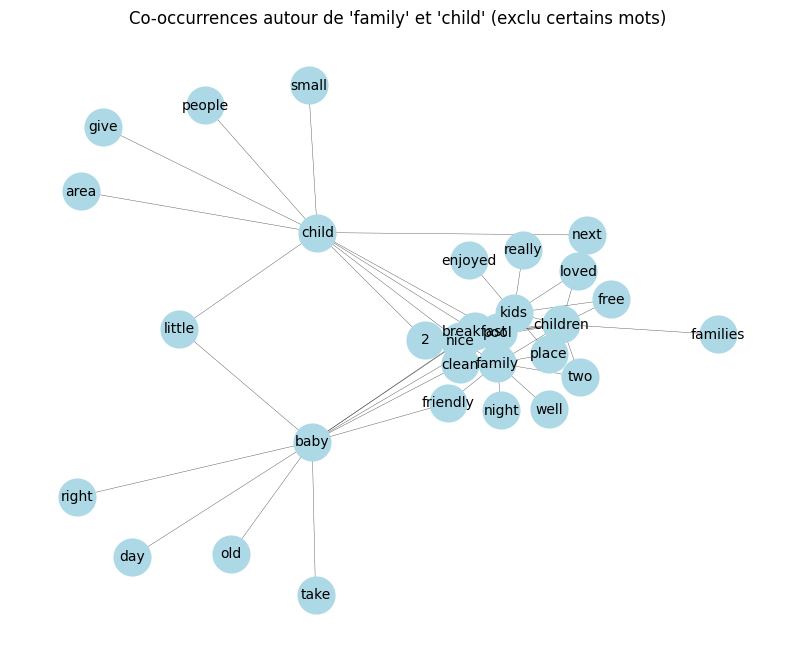

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

documents_tokens = [doc.split() for doc in documents_clean]

# Mots d'intérêt
target_words = {"family", "child", "baby", "children", "kids"}

# Mots à ignorer
exclude_words = {"hotel", "room", "stay", "one", "good", "great", "front", "desk", "time", "us", "rooms",
                 "stayed", "would", "get", "even", "could", "staff", "use", "like"}  # par exemple

co_occurrence_target = defaultdict(int)

for tokens in documents_tokens:
    token_set = set(tokens)
    # Retirer les mots à ignorer
    token_set = token_set - exclude_words
    for target in target_words:
        if target in token_set:
            for word in token_set:
                if word != target:
                    co_occurrence_target[(target, word)] += 1

# Trier et garder top 10 pour chaque mot cible
top_edges = []
for target in target_words:
    edges = [(tgt, w, c) for (tgt, w), c in co_occurrence_target.items() if tgt == target]
    edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)[:10]
    top_edges.extend(edges_sorted)

# Graphe
G = nx.Graph()
for tgt, word, count in top_edges:
    G.add_edge(tgt, word, weight=count)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)
weights = [d['weight'] for (_, _, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Co-occurrences autour de 'family' et 'child' (exclu certains mots)")
plt.axis('off')
plt.show()
